# Crdit Approval Prediction

## Customer Data Preprocessing



This dataset was taken from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/Credit+Approval. 

The features are unlabeled, so we cannot perform feature sampling based on prior knowledge about how the features relate to the output label. We can, however, remove records with multiple erroneous or missing values as these samples could negatively impact the performance of our models. Comprehensively, we will be doing the following preprocessing tasks to prepare the data:

    - Locate missing data/replace with sentinel NaN value
    - Perform record sampling to remove records with more than 1 missing value
    - Fill missing continuous values with column mean
    - Fill missing categorical values with column mode
    - Remove outliers using statistical analysis
    - Perform a One Hot Encoding of the categorical features

In [71]:
#import pandas and numpy
import pandas as pd
import numpy as np

#import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#import train_test_split
from sklearn.model_selection import train_test_split

#import all the required classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [72]:
#read the data from customer.data
df = pd.read_csv('customer.data', header=None)

In [73]:
# replace missing values with sentinel NaN value
df = df.replace('?', np.nan)
df.describe()

,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [74]:
# features 2, 7, 10, and 14 are continuous. None of these contain NaN values.
df.count()

0     678
1     678
2     690
3     684
4     684
5     681
6     681
7     690
8     690
9     690
10    690
11    690
12    690
13    677
14    690
15    690
dtype: int64

In [75]:
# the 10 samples below each contain more than a single error and should be removed
nan_vals = dict(df.count(axis=1))
nan_vals = {key:value for (key,value) in nan_vals.items() if value < 15}
nan_vals

{206: 11,
 270: 11,
 330: 11,
 445: 14,
 456: 11,
 479: 13,
 539: 14,
 592: 11,
 601: 13,
 622: 11}

In [76]:
# drop the erroneous records from the data frame
df = df.drop(index=nan_vals.keys())

In [77]:
# this still leaves us with 680 samples for training/testing
len(df)

680

In [78]:
# there are no missing continuous values; however, there are missing categorical values that we can fill in using the column's
# most frequent value -- the mode.
fill = pd.Series(df.mode().values.flatten())
df = df.fillna(fill)

In [79]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [80]:
df[1] = df[1].astype('float64')
df[13] = df[13].astype('int64')

In [81]:
#know all the datatypes
df.dtypes

0      object
1     float64
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12     object
13      int64
14      int64
15     object
dtype: object

In [82]:
# use describe() to know about the metrics like count, mean, standard deviation e.t.c.
df.describe()

,1,2,7,10,13,14
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,31.309824,4.797515,2.255184,2.435294,182.864706,1024.198529
std,11.718569,4.986291,3.360643,4.889825,174.085346,5244.642160
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.670000,1.000000,0.165000,0.000000,70.000000,0.000000
50%,28.170000,2.855000,1.000000,0.000000,160.000000,5.000000
75%,37.562500,7.500000,2.750000,3.000000,274.500000,400.000000
max,76.750000,28.000000,28.500000,67.000000,2000.000000,100000.000000


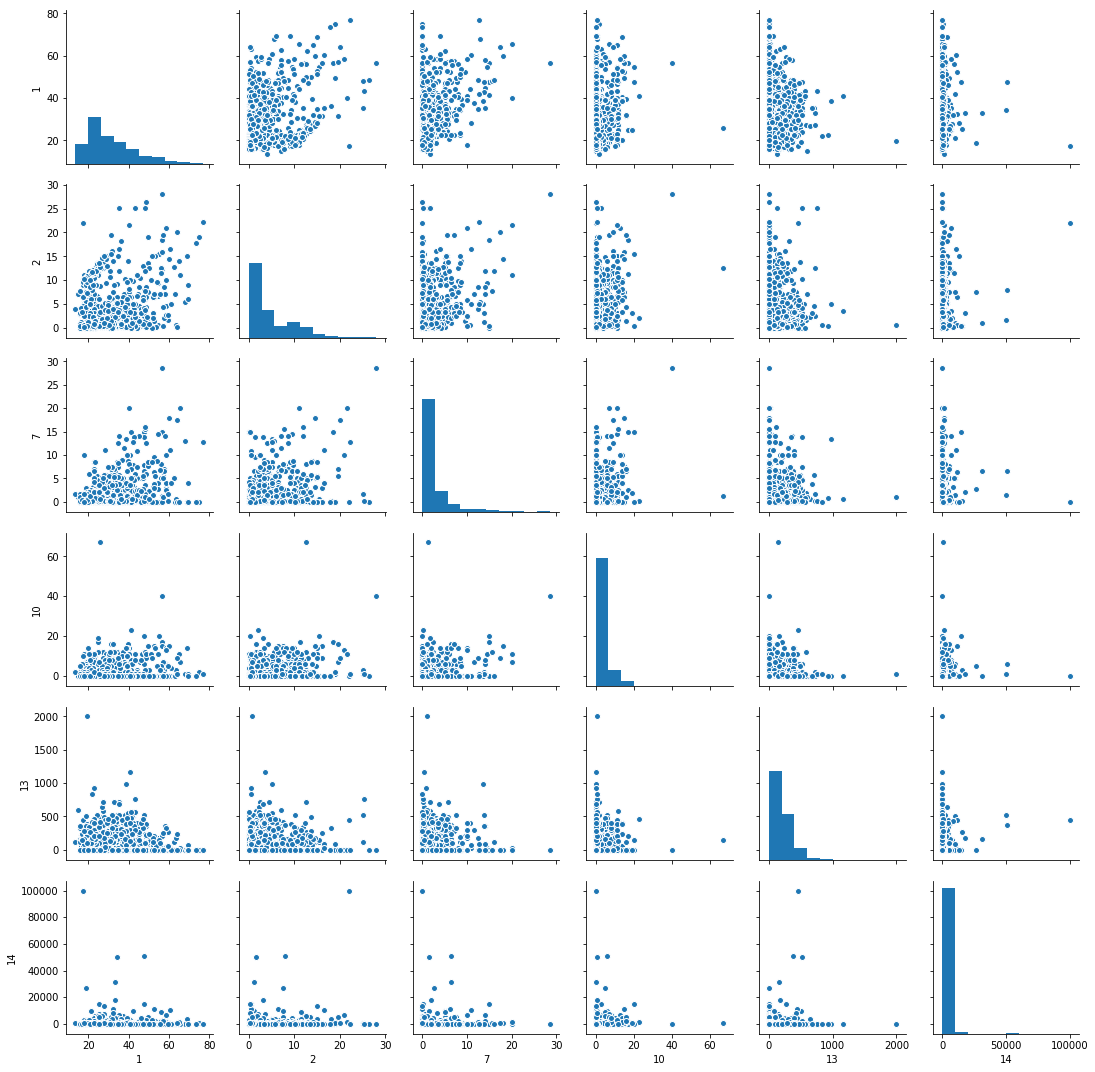

In [83]:
#plot a pairplot for all the numerical features
n=[1,2,7,10,13,14]
sns.pairplot(df[n])

From the above pairplot we cannot clearly visualize the correlation between numerical attributes so we will go with the heatmap to know clearly about the correlation  

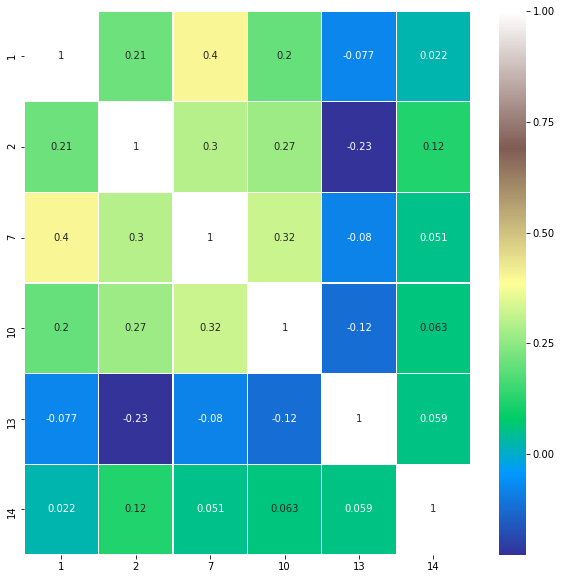

In [84]:
#heatmap to find the correlation.
sns.heatmap(df[n].corr(),annot=True,cmap='terrain',linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

From the above heatmap we can clearly visualize the correlation between the numerical attributes. The correlation between 1 and 7 is 0.4 and correlation between 7 and 10 is 0.32. But these correlations are not too high.
 
Now we will go with the removal of true outliers. If the data in numerical attributes are more than 3 standard deviations away from the mean we will treat them as true outliers. 
 
Here the standard deviation for 1 is 11.719 and mean is 31.310
The standard deviation for 2 is 4.986 and the mean is 4.798
The standard deviation for 7 is 3.361 and the mean is 2.255
The standard deviation for 10 is 4.890 and mean is 2.435
The standard deviation for 13 is 174.085 and the mean is 182.865
the srandard deviation for 14 is 5344.642 and the mean is 1024.199.


In [85]:
# remove only TRUE outliers -- those more than 3 stdev's from the mean
df[(df[1] < 3*11.719 + 31.310) &
   (df[2] < 3*4.986 + 4.798) & 
   (df[7] < 3*3.361 + 2.255) & 
   (df[10] < 3*4.890 + 2.435) &
   (df[13] < 3*174.085 + 182.865) &
   (df[14] < 3*5344.642 + 1024.199)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,43,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,120,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,360,0,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,80,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,180,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,52,1442,+
10,b,22.08,0.830,u,g,c,h,2.165,f,f,0,t,g,128,0,+


In [86]:
# if we knew something about the labels, we would have a better understanding about how to go about
# removing categorical outliers; however, we are not privileged with this understanding because the
# source of the data and the feature labels are unknown. We would proceed to evaluate the categorical
# outliers by viewing the frequencies of occurence for each value per column like so: df[5].value_counts(),
# but we will not be doing that here.
df[3].value_counts()

u    517
y    161
l      2
Name: 3, dtype: int64

In [87]:
# Now, we need to perform a One Hot Encoding of the categorical variables to prepare the data for classification.
# we can do this easily by using the OneHotEncoder from the sklearn.preprocessing module or simply call get_dummies()
# on a pandas data frame. For simplicity, we will use the latter approach.
df = pd.get_dummies(df)
df.head()

,1,2,7,10,13,14,0_a,0_b,3_l,3_u,...,8_t,9_f,9_t,11_f,11_t,12_g,12_p,12_s,15_+,15_-
0,30.83,0.000,1.25,1,202,0,0,1,0,1,...,1,0,1,1,0,1,0,0,1,0
1,58.67,4.460,3.04,6,43,560,1,0,0,1,...,1,0,1,1,0,1,0,0,1,0
2,24.50,0.500,1.50,0,280,824,1,0,0,1,...,1,1,0,1,0,1,0,0,1,0
3,27.83,1.540,3.75,5,100,3,0,1,0,1,...,1,0,1,0,1,1,0,0,1,0
4,20.17,5.625,1.71,0,120,0,0,1,0,1,...,1,1,0,1,0,0,0,1,1,0


In [88]:
# now we can simply drop the duplicate output label column
df = df.drop(columns='15_-')
df.head()

,1,2,7,10,13,14,0_a,0_b,3_l,3_u,...,8_f,8_t,9_f,9_t,11_f,11_t,12_g,12_p,12_s,15_+
0,30.83,0.000,1.25,1,202,0,0,1,0,1,...,0,1,0,1,1,0,1,0,0,1
1,58.67,4.460,3.04,6,43,560,1,0,0,1,...,0,1,0,1,1,0,1,0,0,1
2,24.50,0.500,1.50,0,280,824,1,0,0,1,...,0,1,1,0,1,0,1,0,0,1
3,27.83,1.540,3.75,5,100,3,0,1,0,1,...,0,1,0,1,0,1,1,0,0,1
4,20.17,5.625,1.71,0,120,0,0,1,0,1,...,0,1,1,0,1,0,0,0,1,1


In [89]:
# writing the cleaned data set to a new csv file in the data directory
df.to_csv('clean.csv', sep=',')

#read the cleaned data using read_csv()
df = pd.read_csv('clean.csv')
df = df.iloc[:,1:] # drop first row of index values
df = df.sample(frac=1) # shuffle rows
df.head()

In [90]:
# split data into its X and y components
X, y = df.values[:,:-1], df.values[:,-1]
print(X.shape)
print(y.shape)

(680, 46)
(680,)


In [91]:
#split the training and testing data that is split the total data into 70% training data and 30% testing data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3000)
print ("train_set_x shape: " + str(X_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x shape: " + str(X_test.shape))
print ("test_set_y shape: " + str(y_test.shape))

train_set_x shape: (476, 46)
train_set_y shape: (476,)
test_set_x shape: (204, 46)
test_set_y shape: (204,)


Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data. So we use StandardScaler()


In [92]:
scaler = StandardScaler()
#Fit to data, then transform it. By using fit_transform
X_train = scaler.fit_transform(X_train)
#use transform() to perform standardization
X_test = scaler.transform(X_test)

In [93]:
#write a function train_model which helps us to calculate the accuracy for every classification model. 
def train_model(X_train, y_train, X_test, y_test, classifier, **kwargs):
    
    """
    Fit the chosen model and print out the score.
    
    """
    
    # instantiate model
    model = classifier(**kwargs)
    
    # train model
    model.fit(X_train,y_train)
    
    # check accuracy and print out the results
    fit_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    score=[]
    
    print(f"Train accuracy: {fit_accuracy:0.2%}")
    print(f"Test accuracy: {test_accuracy:0.2%}")
    
    return model

## Benchmark model

 Here we will consider gaussian naive bayes model as the benchmark model.
 We will find out the accuracy of this model and try to achive the better accuracy than this model.

In [94]:
#gaussianNB
model=train_model(X_train,y_train, X_test,y_test, GaussianNB)


Train accuracy: 84.03%
Test accuracy: 84.80%


### We achived the test accuracy of 82.35% using the gaussian naive bayes model now we will try to achive the accuracy greater than this.

#### We will now carry on with the classification models like randomforest, decision tree, knn, svm, logistic regression and try to find the better accuracy than the benchmark model.

In [95]:
#random forest clssifier
model=train_model(X_train,y_train, X_test,y_test, RandomForestClassifier, random_state=3000)

Train accuracy: 98.74%
Test accuracy: 88.73%


In [96]:
#knn
model=train_model(X_train,y_train, X_test,y_test, KNeighborsClassifier)

Train accuracy: 87.39%
Test accuracy: 83.82%


In [97]:
#decisiontree
model=train_model(X_train,y_train, X_test,y_test, DecisionTreeClassifier, random_state=3000)

Train accuracy: 100.00%
Test accuracy: 83.33%


In [98]:
#logistic regression
model=train_model(X_train,y_train, X_test,y_test, LogisticRegression)

Train accuracy: 88.24%
Test accuracy: 88.24%


In [99]:
#svm
model=train_model(X_train,y_train, X_test,y_test, SVC)

Train accuracy: 91.39%
Test accuracy: 87.25%


In [100]:
# initialize an empty list
accuracy = []

# list of algorithms names
classifiers = ['Naive Bayes','KNN', 'Decision Trees', 'Logistic Regression', 'SVM', 'Random Forests']

# list of algorithms with parameters
models = [GaussianNB(),KNeighborsClassifier(), DecisionTreeClassifier(random_state=3000), LogisticRegression(), 
        SVC(), RandomForestClassifier(random_state=3000)]

# loop through algorithms and append the score into the list
for i in models:
    model = i
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    accuracy.append(score)

#### Testing for different random states

In [115]:
#random forest clssifier for random_state=3000
model=train_model(X_train,y_train, X_test,y_test, RandomForestClassifier, random_state=3000)
#random forest clssifier for random_state=3100
model=train_model(X_train,y_train, X_test,y_test, RandomForestClassifier, random_state=3100)
#random forest clssifier for random_state=3200
model=train_model(X_train,y_train, X_test,y_test, RandomForestClassifier, random_state=3200)


Train accuracy: 98.74%
Test accuracy: 88.73%
Train accuracy: 99.16%
Test accuracy: 86.76%
Train accuracy: 97.90%
Test accuracy: 86.76%


The average accuracy score is 87.42% which is very near to the value when we assigned random_state=3000.so from this we can say that small changes in the training data will not effect the results greatly.

In [102]:
# create a dataframe from accuracy results
summary = pd.DataFrame({'accuracy':accuracy}, index=classifiers)       
summary

,accuracy
Naive Bayes,0.848039
KNN,0.838235
Decision Trees,0.833333
Logistic Regression,0.882353
SVM,0.872549
Random Forests,0.887255


### Refinement
Here we will discuss the process of improvement I made up on the algorithms and techniques use in my previous implimentation. In the above section I got  random forest accuracy more then any other . now I will try to refine it for obtaining better accuracy . Here we will use GridSearchCV()

In [103]:
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=3000)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [40,50], 
              'criterion': ['gini', 'entropy']}

# TODO: Make an fbeta_score scoring object


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring='accuracy')

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions 
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)



print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))



Optimized Model
------
Final accuracy score on the testing data: 0.8873


#### By tuning the random forest classifier I achived an accuracy of  which is better than the untuned model. 

## Conclusion:
   Out of the above chosen models Random Forest yields the better accuracy of 0.9069 than the other models. By using all the above  models we get better accuracy than the benchmark model. But out of those we can see that the Random Forest have the better accuracy than the others. So I can say that the Random Forest is the better algorithm which can be used to predict whether the credit card can be approved to the customer or not.

### Visuvaliztion of the accuracy

<BarContainer object of 7 artists>

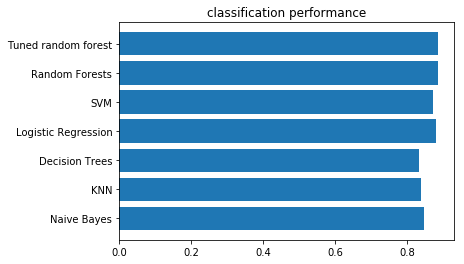

In [104]:
x_axis=['Naive Bayes','KNN', 'Decision Trees', 'Logistic Regression', 'SVM', 'Random Forests','Tuned random forest']
y_axis=[0.848039,0.838235,0.833333,0.882353,0.872549,0.887255,0.8873]
plt.title('classification performance')
plt.barh(x_axis,y_axis)